# Walmart forecasting

## Table of Contents
1. [Abstract](#abstract)
2. [Introduction](#intro)
3. [Environment](#environ)
4. [Functions](#func)
5. [EDA](#eda)
    1. [Calendar](#eda_calendar)
    2. [Price](#eda_price)
    3. [Sales train validation](#eda_sales)
6. [Scoping](#scope)
7. [Baseline Forecast](#forecast)
    1. [Data munging](#munge)
    2. [Stationary data](#stationary)
    3. [ARIMA](#arima)
    4. [ETS](#ets)
8. [Conclusion](#concl)

<a name='abstract'></a>
## 1. Abstract

TBD

<a name='intro'></a>
## 2. Introduction

### Competition goals
- Predict accurate forecast for each of 42,840 time series
- Forecast daily sales for the next 28 days
- Corresponding median, 50/67/95/99% prediction intervals

### Personal goals
- Forecast daily sales for one item in one store for next 28 days
- Feature engineering to help improve forecasting
- Develop script to automatically choose forecasting method for a given time series

### Data
https://www.kaggle.com/c/m5-forecasting-accuracy/overview

- Hierarchical sales data from Walmart 
- Includes item level, department, product categories, and store details
- Includes price, promotions, day of the week, and special events
- Unit sales of 3,049 products, classified in 3 product categories (Hobbies, Foods, Household) and 8 product departments
- Sold across 10 stores in 3 states (CA, TX, WI)

**calendar.csv**: Contains information about the dates on which the products are sold.
- date
- wm_yr_wk: id of the week the date belongs to
- weekday
- wday: id of weekday, starting from Saturday
- month
- year
- event_name_1: event name, if any
- event_type_1: type of event, if any
- event_name_2: second event name, if any
- event_type_2: second event type, if any
- snap_CA/TX/WI: boolean whether store in CA/TX/WI allow SNAP purchases on the examined date (1: yes)

**sales_train_validation.csv**: Contains the historical daily unit sales data per product and store (d_1 - d_1913)
- store_id
- item_id
- wm_yr_wk
- sell_price: if not available, product not sold during the examined week, price may change through time

**sell_prices.csv**: Contains information about the price of the products sold per store and date.
- item_id
- dept_id
- cat_id: id of category of product
- store_id
- state_id
- d_1, d_2, ... d_1941: Number of units sold at day i starting from 2011_01_29

<a name='environ'></a>
## 3. Environment

In [194]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas_profiling import ProfileReport

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

<a name='func'></a>
## 4. Functions

In [134]:
def test_stationarity(timeseries, window):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
                         
    #Plot rolling statistics:
    f, ax = plt.subplots(figsize=(15, 7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [195]:
# may want to add trend/seasonality decomposition function here

<a name='eda'></a>
## 5. EDA

<a name='eda_calendar'></a>
### 5.1. Calendar

In [3]:
# load calendar data
calendar_df = pd.read_csv('./data/calendar.csv')

In [5]:
calendar_df.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [7]:
calendar_profile = ProfileReport(calendar_df, title='Calendar Profiling Report', html={'style':{'full_width':True}})

In [8]:
calendar_profile.to_notebook_iframe()

- 14 columns
- 1969 observations
- 27.4% missing values: all in event-related cells
- no duplicate rows

- date: unique, categorical => change to datetime
- wm_yr_wk: id => change to categorical? Is this in any order?
- offer SNAP ~33% of the time?

<a name='eda_price'></a>
### 5.2. Price

In [9]:
# load price data
price_df = pd.read_csv('./data/sell_prices.csv')

In [12]:
price_df.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [10]:
price_profile = ProfileReport(price_df, title='Price Profiling Report', html={'style':{'full_width':True}})

In [11]:
price_profile.to_notebook_iframe()

- no missing values
- no duplicates

<a name='eda_sales'></a>
### 5.3.Sales train validation

In [13]:
sales_df = pd.read_csv('./data/sales_train_validation.csv')

In [14]:
sales_df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [16]:
# if I do profiling on full df, it will take too much resources
sales_profile = ProfileReport(sales_df[['item_id', 'dept_id', 'cat_id', 'store_id']], title='Sales Profiling Report', html={'style':{'full_width':True}})

In [17]:
sales_profile.to_notebook_iframe()

- no missing values
- no duplicates
- different departments & categories have different number of items in it
- dept_id is \[cat_id]_[dept_id_number]
- item_id is \[dept_id]_[item_id_number]
- store_id is \[state]_[store_number]
- 3 stores in TX & WI, 4 stores in CA

In [18]:
sales_df.describe()

d_1           d_2           d_3           d_4           d_5  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       1.070220      1.041292      0.780026      0.833454      0.627944   
std        5.126689      5.365468      3.667454      4.415141      3.379344   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      360.000000    436.000000    207.000000    323.000000    296.000000   

                d_6           d_7           d_8           d_9          d_10  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       0.958052      0.918662      1.244080      1.073663      0.838701   
std        4.785947      5.059495      6.617729      5.917204      4.206199   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      314.000000    316.000000    370.000000    385.000000    353.000000   

       ...        d_1904        d_1905        d_1906        d_1907  \
count  ...  30490.000000  30490.000000  30490.000000  30490.000000   
mean   ...      1.370581      1.586159      1.693670      1.248245   
std    ...      3.740017      4.097191      4.359809      3.276925   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      1.000000      2.000000      2.000000      1.000000   
max    ...    129.000000    160.000000    204.000000     98.000000   

             d_1908        d_1909        d_1910        d_1911        d_1912  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       1.232207      1.159167      1.149000      1.328862      1.605838   
std        3.125471      2.876026      2.950364      3.358012      4.089422   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      1.000000      2.000000   
max      100.000000     88.000000     77.000000    141.000000    171.000000   

             d_1913  
count  30490.000000  
mean       1.633158  
std        3.812248  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        2.000000  
max      130.000000  

[8 rows x 1913 columns]

In [23]:
sales_df.describe().loc['max'].max()

763.0

- amount of item sold can be up to 763 for a single item

<a name='scope'></a>
## 6. Scoping

This is a relatively clean dataset. 

Let's limit the scope to forecast one item's sales for a given store. 

**Which item and which store?**
Let's choose the one with most dynamic range, which suggests that the sales is very dynamic. This could be more useful to have forecasting information rather than something that might be more of a staple and has consistent sales. Look for high max and low min (presumably 0).

In [26]:
sales_df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [38]:
sales_df.loc[2].iloc[6:].max()

6

In [42]:
# max & min amount sold in one day
sales_df.loc[:, 'max_sold_in_day'] = sales_df.max(axis=1, numeric_only=True).astype(int)
sales_df.loc[:, 'min_sold_in_day'] = sales_df.min(axis=1, numeric_only=True).astype(int)
sales_df.loc[:, 'sales_range'] = sales_df.max_sold_in_day - sales_df.min_sold_in_day

In [43]:
sales_df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1907  d_1908  d_1909  d_1910  d_1911  \
0       CA    0    0    0    0  ...       1       1       1       3       0   
1       CA    0    0    0    0  ...       0       0       1       0       0   
2       CA    0    0    0    0  ...       1       1       1       0       1   
3       CA    0    0    0    0  ...       4       1       0       1       3   
4       CA    0    0    0    0  ...       0       1       1       2       2   

   d_1912  d_1913  max_sold_in_day  min_sold_in_day  sales_range  
0       1       1                5                0            5  
1       0       0                5                0            5  
2       1       1                6                0            6  
3       7       2               15                0           15  
4       2       4                9                0            9  

[5 rows x 1922 columns]

In [44]:
sales_df.sales_range.max()

763

In [45]:
sales_df[sales_df.sales_range == 763]

id      item_id  dept_id cat_id store_id  \
8412  FOODS_3_090_CA_3_validation  FOODS_3_090  FOODS_3  FOODS     CA_3   

     state_id  d_1  d_2  d_3  d_4  ...  d_1907  d_1908  d_1909  d_1910  \
8412       CA  108  132  102  120  ...      86     100      88      77   

      d_1911  d_1912  d_1913  max_sold_in_day  min_sold_in_day  sales_range  
8412     141     139     130              763                0          763  

[1 rows x 1922 columns]

In [48]:
sales_df[sales_df.sales_range == 763].mean(axis=1, numeric_only=True)

8412    131.538622
dtype: float64

In [47]:
sales_df[sales_df.sales_range == 763].std(axis=1, numeric_only=True)

8412    110.471045
dtype: float64

**FOODS_3_090 in store CA_3 has the biggest range (0-763) with mean of 131.53 and stdev of 110.47.**

Let's use this series (index 8412) for forecasting.

<a name='forecast'></a>
## 7. Baseline Forecast

<a name='munge'></a>
### 7.1. Data munging

Get data is already pretty clean; just get it in form that is convenient.

In [67]:
# extract sales data w/o meta data
df = sales_df[sales_df.sales_range == 763]
df = df.iloc[:, 6:-3].T
df

8412
d_1      108
d_2      132
d_3      102
d_4      120
d_5      106
...      ...
d_1909    88
d_1910    77
d_1911   141
d_1912   139
d_1913   130

[1913 rows x 1 columns]

In [68]:
df.reset_index(inplace=True)

In [69]:
df.rename({'index': 'd',
           8412: 'unit_sold'}, axis=1, inplace=True)

**Check date range to see if there are any discrepancies between sales and calendar data.**

In [70]:
df.head()

d  unit_sold
0  d_1        108
1  d_2        132
2  d_3        102
3  d_4        120
4  d_5        106

In [73]:
df.tail()

d  unit_sold
1908  d_1909         88
1909  d_1910         77
1910  d_1911        141
1911  d_1912        139
1912  d_1913        130

In [72]:
df.shape

(1913, 2)

In [66]:
calendar_df.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [74]:
calendar_df.tail()

date  wm_yr_wk    weekday  wday  month  year       d  \
1964  2016-06-15     11620  Wednesday     5      6  2016  d_1965   
1965  2016-06-16     11620   Thursday     6      6  2016  d_1966   
1966  2016-06-17     11620     Friday     7      6  2016  d_1967   
1967  2016-06-18     11621   Saturday     1      6  2016  d_1968   
1968  2016-06-19     11621     Sunday     2      6  2016  d_1969   

      event_name_1 event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  \
1964           NaN          NaN           NaN          NaN        0        1   
1965           NaN          NaN           NaN          NaN        0        0   
1966           NaN          NaN           NaN          NaN        0        0   
1967           NaN          NaN           NaN          NaN        0        0   
1968  NBAFinalsEnd     Sporting  Father's day     Cultural        0        0   

      snap_WI  
1964        1  
1965        0  
1966        0  
1967        0  
1968        0

In [71]:
calendar_df.shape

(1969, 14)

**Calendar has up to d_1969; the sales only has up to d_1913. There appears to be no gap in dates.**

In [76]:
# merge sales and calendar information
df = pd.merge(df, calendar_df, how='left', on='d', sort=False)

In [78]:
# drop other state snap info
df.drop(['snap_TX', 'snap_WI'], axis=1, inplace=True)

In [79]:
df

d  unit_sold        date  wm_yr_wk    weekday  wday  month  year  \
0        d_1        108  2011-01-29     11101   Saturday     1      1  2011   
1        d_2        132  2011-01-30     11101     Sunday     2      1  2011   
2        d_3        102  2011-01-31     11101     Monday     3      1  2011   
3        d_4        120  2011-02-01     11101    Tuesday     4      2  2011   
4        d_5        106  2011-02-02     11101  Wednesday     5      2  2011   
...      ...        ...         ...       ...        ...   ...    ...   ...   
1908  d_1909         88  2016-04-20     11612  Wednesday     5      4  2016   
1909  d_1910         77  2016-04-21     11612   Thursday     6      4  2016   
1910  d_1911        141  2016-04-22     11612     Friday     7      4  2016   
1911  d_1912        139  2016-04-23     11613   Saturday     1      4  2016   
1912  d_1913        130  2016-04-24     11613     Sunday     2      4  2016   

     event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  
0             NaN          NaN          NaN          NaN        0  
1             NaN          NaN          NaN          NaN        0  
2             NaN          NaN          NaN          NaN        0  
3             NaN          NaN          NaN          NaN        1  
4             NaN          NaN          NaN          NaN        1  
...           ...          ...          ...          ...      ...  
1908          NaN          NaN          NaN          NaN        0  
1909          NaN          NaN          NaN          NaN        0  
1910          NaN          NaN          NaN          NaN        0  
1911          NaN          NaN          NaN          NaN        0  
1912          NaN          NaN          NaN          NaN        0  

[1913 rows x 13 columns]

In [64]:
# price of the specified item in specified store
limited_price_df = price_df[(price_df.store_id == 'CA_3') & (price_df.item_id == 'FOODS_3_090')]

In [83]:
# check price_df range
limited_price_df.shape

(282, 4)

In [85]:
limited_price_df.wm_yr_wk.nunique()

282

In [87]:
df.wm_yr_wk.nunique()

274

In [88]:
set(limited_price_df.wm_yr_wk.unique()) - set(df.wm_yr_wk.unique())

{11614, 11615, 11616, 11617, 11618, 11619, 11620, 11621}

In [89]:
set(df.wm_yr_wk.unique()) - set(limited_price_df.wm_yr_wk.unique())

set()

**There are 8 more weeks in price_df**

In future, for predicting all items in all stores, it might be better to join calendar & price, cache, and then to join with sales.

In [90]:
# merge in price information
df = pd.merge(df, limited_price_df[['wm_yr_wk', 'sell_price']], how='left', on='wm_yr_wk', sort=False)

In [99]:
# change date to datetime datatype
df.loc[:, 'date'] = pd.to_datetime(df.date)

In [103]:
# add sales amount
df.loc[:, 'sales_amount'] = df.unit_sold * df.sell_price

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1913 entries, 0 to 1912
Data columns (total 15 columns):
d               1913 non-null object
unit_sold       1913 non-null int64
date            1913 non-null datetime64[ns]
wm_yr_wk        1913 non-null int64
weekday         1913 non-null object
wday            1913 non-null int64
month           1913 non-null int64
year            1913 non-null int64
event_name_1    154 non-null object
event_type_1    154 non-null object
event_name_2    4 non-null object
event_type_2    4 non-null object
snap_CA         1913 non-null int64
sell_price      1913 non-null float64
sales_amount    1913 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(6), object(6)
memory usage: 319.1+ KB


In [106]:
df.head()

d  unit_sold       date  wm_yr_wk    weekday  wday  month  year  \
0  d_1        108 2011-01-29     11101   Saturday     1      1  2011   
1  d_2        132 2011-01-30     11101     Sunday     2      1  2011   
2  d_3        102 2011-01-31     11101     Monday     3      1  2011   
3  d_4        120 2011-02-01     11101    Tuesday     4      2  2011   
4  d_5        106 2011-02-02     11101  Wednesday     5      2  2011   

  event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  sell_price  \
0          NaN          NaN          NaN          NaN        0        1.25   
1          NaN          NaN          NaN          NaN        0        1.25   
2          NaN          NaN          NaN          NaN        0        1.25   
3          NaN          NaN          NaN          NaN        1        1.25   
4          NaN          NaN          NaN          NaN        1        1.25   

   sales_amount  
0         135.0  
1         165.0  
2         127.5  
3         150.0  
4         132.5

In [107]:
item_profile = ProfileReport(df, title='Item Profiling Report', html={'style':{'full_width':True}})

In [108]:
item_profile.to_notebook_iframe()

<a name='stationary'></a>
### 7.2. Stationary data

**Raw data trend**

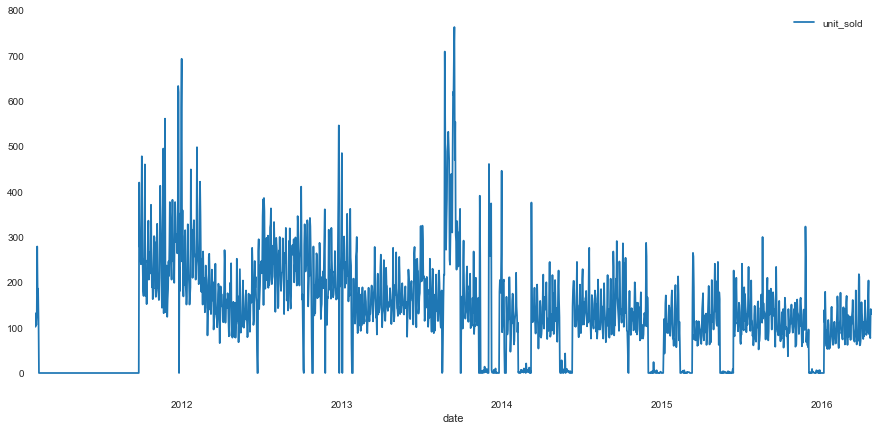

In [112]:
f, ax = plt.subplots(figsize=(15, 7))
df.plot(kind='line', x='date', y='unit_sold', ax=ax);

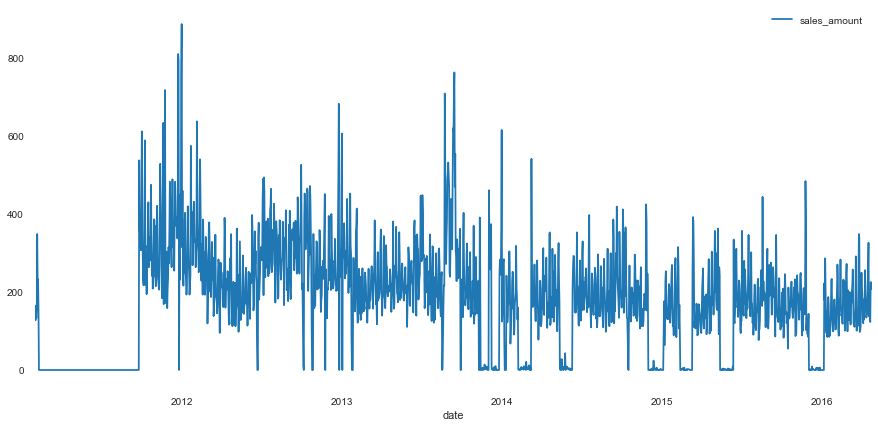

In [113]:
f, ax = plt.subplots(figsize=(15, 7))
df.plot(kind='line', x='date', y='sales_amount', ax=ax);

There might be a downward trend with some seasonal pattern? Too noisy to tell.

It is also weird that there is a huge gap in the beginning. Is it possible that this item was not offerred for a period of time (e.g. not stocked)? A gap of more than half a year with no sales seems weird.

**Explore the gap in sales in 2011.**

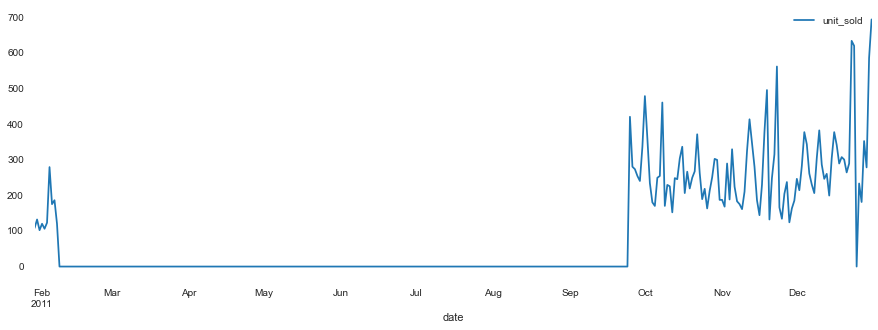

In [150]:
f, ax = plt.subplots(figsize=(15, 5))
df[df.year == 2011].plot(kind='line', x='date', y='unit_sold', ax=ax);

Flag if rolling mean of 28 days is 0.

In [154]:
df.loc[:, 'flag'] = df.unit_sold.rolling(28).mean() == 0

In [156]:
df[df.flag]

d  unit_sold       date  wm_yr_wk    weekday  wday  month  year  \
37    d_38          0 2011-03-07     11106     Monday     3      3  2011   
38    d_39          0 2011-03-08     11106    Tuesday     4      3  2011   
39    d_40          0 2011-03-09     11106  Wednesday     5      3  2011   
40    d_41          0 2011-03-10     11106   Thursday     6      3  2011   
41    d_42          0 2011-03-11     11106     Friday     7      3  2011   
..     ...        ...        ...       ...        ...   ...    ...   ...   
234  d_235          0 2011-09-20     11134    Tuesday     4      9  2011   
235  d_236          0 2011-09-21     11134  Wednesday     5      9  2011   
236  d_237          0 2011-09-22     11134   Thursday     6      9  2011   
237  d_238          0 2011-09-23     11134     Friday     7      9  2011   
238  d_239          0 2011-09-24     11135   Saturday     1      9  2011   

    event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  sell_price  \
37           NaN          NaN          NaN          NaN        1        1.25   
38           NaN          NaN          NaN          NaN        1        1.25   
39     LentStart    Religious          NaN          NaN        1        1.25   
40           NaN          NaN          NaN          NaN        1        1.25   
41           NaN          NaN          NaN          NaN        0        1.25   
..           ...          ...          ...          ...      ...         ...   
234          NaN          NaN          NaN          NaN        0        1.25   
235          NaN          NaN          NaN          NaN        0        1.25   
236          NaN          NaN          NaN          NaN        0        1.25   
237          NaN          NaN          NaN          NaN        0        1.25   
238          NaN          NaN          NaN          NaN        0        1.28   

     sales_amount  rolling_mean_unit_sold  rolling_std_unit_sold  \
37            0.0                     0.0               0.000003   
38            0.0                     0.0               0.000003   
39            0.0                     0.0               0.000003   
40            0.0                     0.0               0.000003   
41            0.0                     0.0               0.000003   
..            ...                     ...                    ...   
234           0.0                     0.0               0.000003   
235           0.0                     0.0               0.000003   
236           0.0                     0.0               0.000003   
237           0.0                     0.0               0.000003   
238           0.0                     0.0               0.000003   

     rolling_mean_sales_amount  rolling_std_sales_amount  flag  
37                         0.0                  0.000004  True  
38                         0.0                  0.000004  True  
39                         0.0                  0.000004  True  
40                         0.0                  0.000004  True  
41                         0.0                  0.000004  True  
..                         ...                       ...   ...  
234                        0.0                  0.000004  True  
235                        0.0                  0.000004  True  
236                        0.0                  0.000004  True  
237                        0.0                  0.000004  True  
238                        0.0                  0.000004  True  

[202 rows x 20 columns]

**From 2011-03-07 to 2011-09-24, there were no units sold of this item. This is over 6 months of gap, which is an anomaly, and I will continue forth only analyzing data from 2011-10-01.**

In [163]:
clean_df = df[df.date > dt.date(2011, 10, 1)]

**Dickey-Fuller Test**

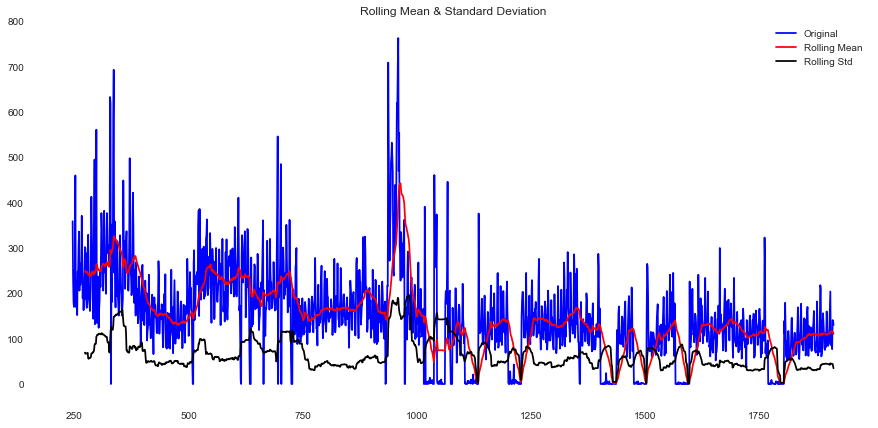

Results of Dickey-Fuller Test:
Test Statistic                   -4.261882
p-value                           0.000517
#Lags Used                       24.000000
Number of Observations Used    1642.000000
Critical Value (1%)              -3.434339
Critical Value (5%)              -2.863302
Critical Value (10%)             -2.567708
dtype: float64


In [164]:
test_stationarity(clean_df[['unit_sold']], window=28)

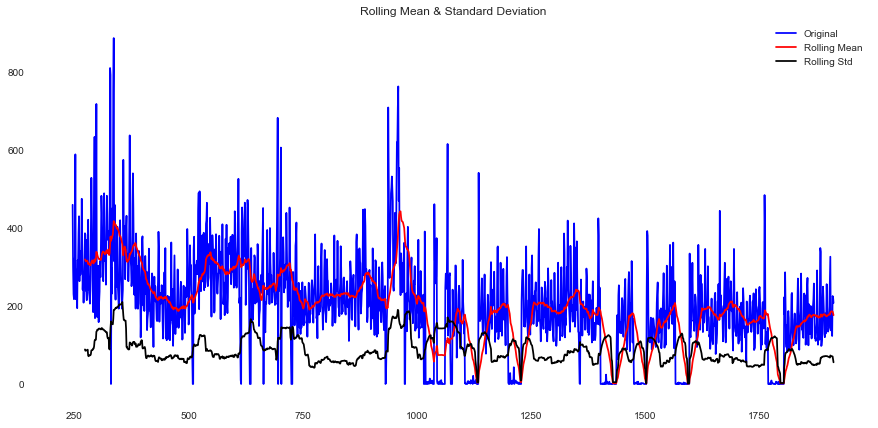

Results of Dickey-Fuller Test:
Test Statistic                   -4.504444
p-value                           0.000193
#Lags Used                       24.000000
Number of Observations Used    1642.000000
Critical Value (1%)              -3.434339
Critical Value (5%)              -2.863302
Critical Value (10%)             -2.567708
dtype: float64


In [165]:
test_stationarity(clean_df[['sales_amount']], window=28)

In both unit_sold and sales_amount, test statistic is lower than critical values. This suggests that the time series is stationary.

Let's see if we can this even more stationary.

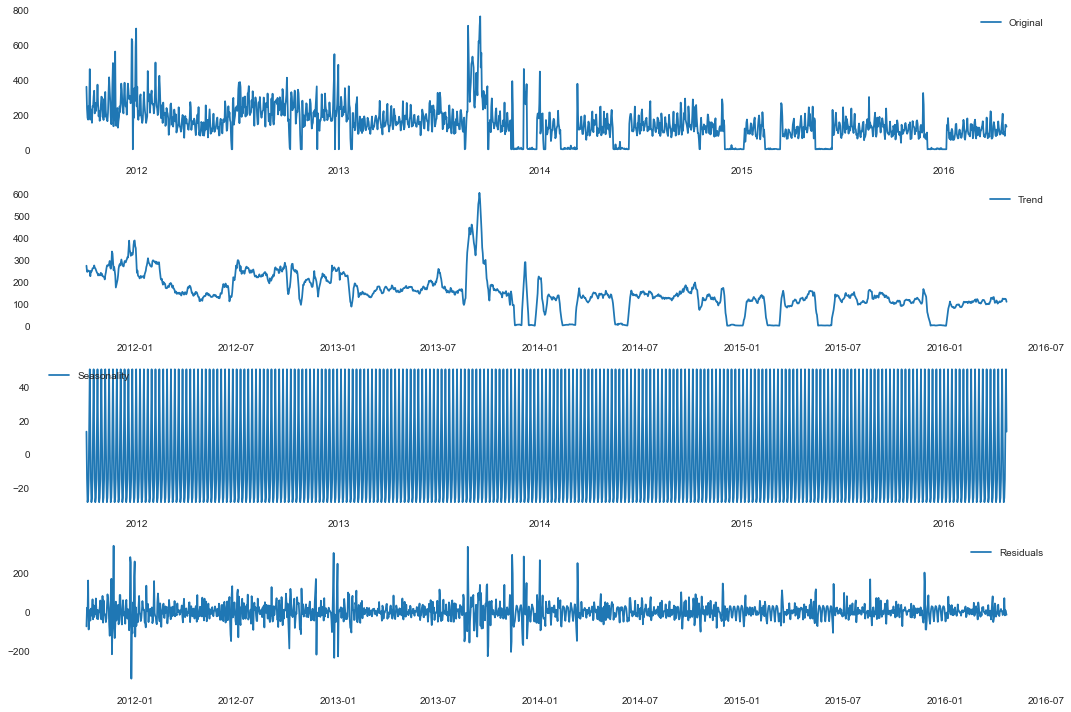

In [196]:
# 0 values, so multiplicative can be problematic unless I add pseudo value
graph_df = clean_df[['date', 'unit_sold']].set_index('date')
decomposition = seasonal_decompose(graph_df, model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

f, ax = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
plt.subplot(411)
plt.plot(graph_df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

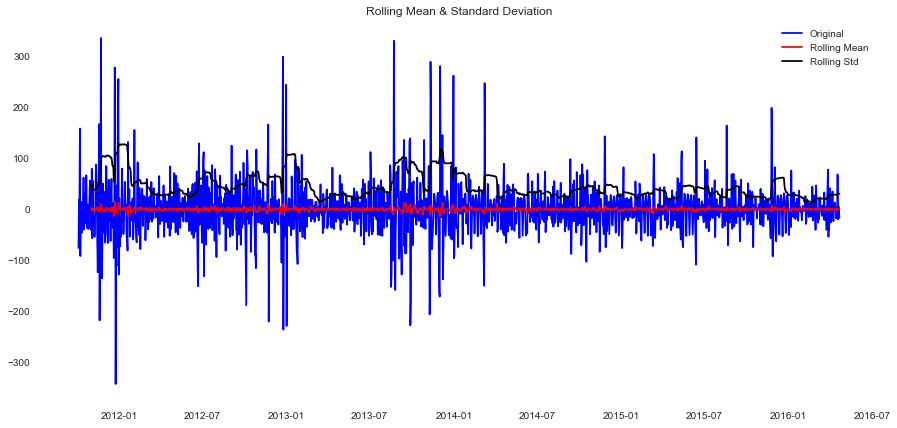

Results of Dickey-Fuller Test:
Test Statistic                -1.628867e+01
p-value                        3.355472e-29
#Lags Used                     2.400000e+01
Number of Observations Used    1.636000e+03
Critical Value (1%)           -3.434353e+00
Critical Value (5%)           -2.863308e+00
Critical Value (10%)          -2.567711e+00
dtype: float64


In [197]:
test_stationarity(residual.dropna(), 28)

<a name='arima'></a>
### 7.3. ARIMA

In [201]:
residual.shape

(1667,)

In [202]:
residual.dropna().shape

(1661,)

In [206]:
residual[residual.isna()]

date
2011-10-02   NaN
2011-10-03   NaN
2011-10-04   NaN
2016-04-22   NaN
2016-04-23   NaN
2016-04-24   NaN
Name: resid, dtype: float64

First few & last few habe been dropped.

In [212]:
# save last 28 for validation
new_residual = residual.dropna().iloc[:-28]
lag_acf = acf(new_residual, nlags=20)
lag_pacf = pacf(new_residual, nlags=20, method='ols')

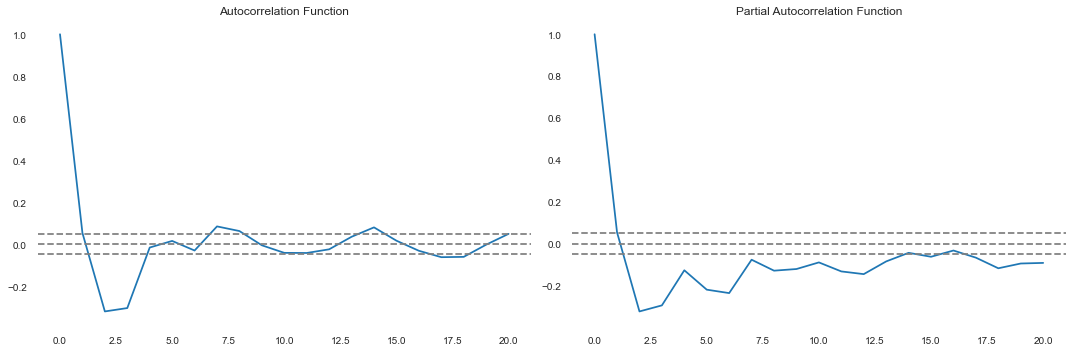

In [214]:
# Plot ACF 
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_residual)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_residual)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_residual)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_residual)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

- p: lag value where PACF chart crosses upper confidence interval for the first time => 1
- q: lag value where ACF chart crosses upper confidence interval for the first time => 1

lag-1 ACF value is positive, which suggests AR, but ACF cut off shaply after lag-3 which suggests MA.